<a href="https://colab.research.google.com/github/AniaSiw/MachineLearning-bootcamp/blob/main/Kopia_notatnika_Praca_in%C5%BCynierska_subtract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Zaimportowanie danych**

In [1]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Praca_inzynierska/PKG-CDD-CESM.zip", 'r')
zip_ref.extractall("/tmp")

In [3]:
!unzip -u "/content/drive/MyDrive/Praca_inzynierska/PKG-CDD-CESM.zip" -d "/content/drive/MyDrive/Praca_inzynierska"

Archive:  /content/drive/MyDrive/Praca_inzynierska/PKG-CDD-CESM.zip


### **Wczytanie danych i zaimportowanie bibliotek**

In [4]:
import os
import csv
import numpy as np
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
data_path = r'/content/drive/MyDrive/Praca_inzynierska/PKG - CDD-CESM/CDD-CESM'

subtracted_images_path = os.path.join(data_path, 'Subtracted images of CDD-CESM')
subtracted_images = [[x] for x in os.listdir(subtracted_images_path)]

print(f"zbiór subtracted: {len(subtracted_images)}")

zbiór subtracted: 1003


In [6]:
subtracted_images[0]

['P109_L_CM_CC.jpg']

In [7]:
all_data_raw = pd.read_csv('/content/drive/MyDrive/Praca_inzynierska/PKG - CDD-CESM/CDD-CESM/Radiology manual annotation.csv', sep=';')
all_data = all_data_raw.copy()
all_data = all_data[['Image_name', 'Pathology Classification/ Follow up']]

In [8]:
all_data.head()

,Image_name,Pathology Classification/ Follow up
0,P1_L_DM_MLO,Malignant
1,P1_L_CM_MLO,Malignant
2,P2_R_DM_CC,Benign
3,P2_R_DM_MLO,Benign
4,P2_R_CM_CC,Benign


In [9]:
# Benign = 0 (łagodny), Malignant = 1 (złośliwy), Normal = 2 (brak zmiany)
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
all_data['Pathology Classification/ Follow up'] = encoder.fit_transform(all_data['Pathology Classification/ Follow up'])

In [10]:
all_data.head()

,Image_name,Pathology Classification/ Follow up
0,P1_L_DM_MLO,1
1,P1_L_CM_MLO,1
2,P2_R_DM_CC,0
3,P2_R_DM_MLO,0
4,P2_R_CM_CC,0


In [11]:
import tensorflow as tf
from PIL import ImageOps
from collections import namedtuple

def load_image(image_path):
  image = Image.open(image_path, 'r')
  return image

def transform_image(img):
    #konwersja do skali szarości
    img = img.resize((255, 255))
    img = ImageOps.grayscale(img)
    
    # konwersja na tensor 
    img = np.asarray(img)
    img = tf.convert_to_tensor(img)
    img = tf.cast(img, dtype=tf.float32)

    # Normalizacja do wartości 0-1
    img = tf.divide(tf.subtract(img, tf.reduce_min(img)), tf.subtract(tf.reduce_max(img), tf.reduce_min(img)))
    return img

def prepare_images(image_path):
  return transform_image(load_image(image_path))

In [12]:
subtracted = list()
for image in subtracted_images:
  for i in range(len(all_data)):
    if (image[0][:-4] == all_data['Image_name'][i]):
      subtracted_image_path = os.path.join(subtracted_images_path, image[0])
      img = prepare_images(subtracted_image_path)
      subtracted.append((img, all_data['Pathology Classification/ Follow up'][i]))

In [13]:
subtracted[0]

(<tf.Tensor: shape=(255, 255), dtype=float32, numpy=
 array([[0.50980395, 0.3254902 , 0.14117648, ..., 0.        , 0.        ,
         0.        ],
        [0.7372549 , 0.627451  , 0.49411765, ..., 0.        , 0.        ,
         0.        ],
        [0.6901961 , 0.64705884, 0.5921569 , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.5019608 , 0.36078432, 0.2627451 , ..., 0.        , 0.        ,
         0.        ],
        [0.654902  , 0.5176471 , 0.3882353 , ..., 0.        , 0.        ,
         0.        ],
        [0.9019608 , 0.7254902 , 0.5568628 , ..., 0.        , 0.        ,
         0.        ]], dtype=float32)>, 2)

In [14]:
del all_data
del all_data_raw
del subtracted_image_path
del subtracted_images
del subtracted_images_path

In [15]:
subtracted_malignant = list()
subtracted_benign = list()
subtracted_normal = list()

for item in subtracted:
  if item[1] == 0:
    subtracted_benign.append(item)
  elif item[1] == 1:
    subtracted_malignant.append(item)
  else:
    subtracted_normal.append(item)

In [16]:
del subtracted

### **Podział zbioru na treningowy, testowy i walidacyjny**

In [17]:
from sklearn.model_selection import train_test_split
import random

# Benign
benign_train, benign_test = train_test_split(subtracted_benign, test_size = 0.3, shuffle = True)
benign_test, benign_valid = train_test_split(benign_test, test_size = 0.3, shuffle = True)

# Malignant
malignant_train, malignant_test = train_test_split(subtracted_malignant, test_size = 0.3, shuffle = True)
malignant_test, malignant_valid = train_test_split(malignant_test, test_size = 0.3, shuffle = True)

# Normal
normal_train, normal_test = train_test_split(subtracted_normal, test_size = 0.3, shuffle = True)
normal_test, normal_valid = train_test_split(normal_test, test_size = 0.3, shuffle = True)

# Training set
training_set = benign_train + malignant_train + normal_train
random.shuffle(training_set)

# Testing set
testing_set = benign_test + malignant_test + normal_test
random.shuffle(testing_set)

# Validation set
validation_set = benign_valid + malignant_valid + normal_valid
random.shuffle(validation_set)

In [18]:
del benign_train
del benign_test
del benign_valid
del normal_train
del normal_test
del normal_valid
del malignant_train
del malignant_test
del malignant_valid

In [19]:
print(f"Zbiór treningowy:  {len(training_set)}")
print(f"Zbiór testowy: {len(testing_set)}")
print(f"Zbiór walidacyjny: {len(validation_set)}")

Zbiór treningowy:  700
Zbiór testowy: 209
Zbiór walidacyjny: 92


In [20]:
# Sprawdzenie, czy zbiory zostały poprawnie podzielone
training_set_list = [x[1] for x in training_set]
testing_set_list = [x[1] for x in testing_set]
validation_set_list = [x[1] for x in validation_set]
print(f"Train: \n{pd.Series(training_set_list).value_counts()}")
print(f"Test: \n{pd.Series(testing_set_list).value_counts()}")
print(f"Validation: \n{pd.Series(validation_set_list).value_counts()}")

Train: 
2    290
1    231
0    179
dtype: int64
Test: 
2    87
1    69
0    53
dtype: int64
Validation: 
2    38
1    30
0    24
dtype: int64


### **Wizualizacja danych**

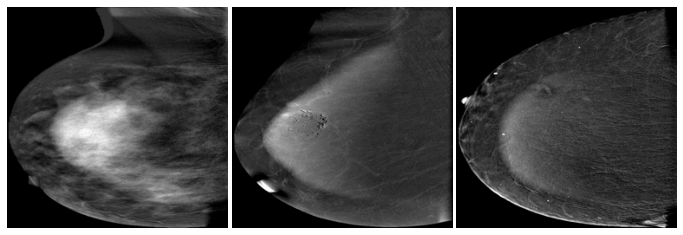

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12,12))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 3),  # creates 4x4 grid of axes
                 axes_pad=0.05)

imgs_to_plot = [training_set[x]for x in range(96, 700, 32)] #taki przedział, żeby uzyskać obrazy z dwóch klas (dane nie są jeszcze pomieszane na tym etapie)
for ax, im in zip(grid, imgs_to_plot):
    ax.imshow(im[0], cmap='gray')
    ax.axis('off')

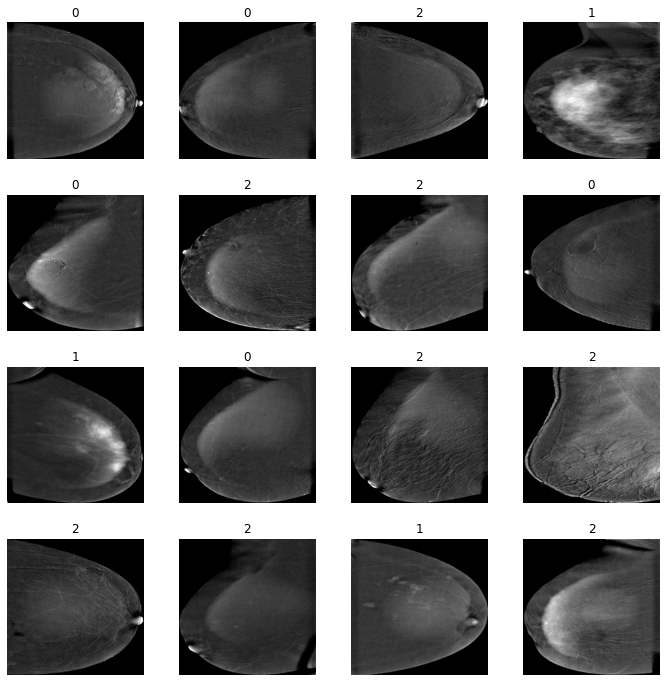

In [ ]:
fig = plt.figure(figsize=(12,12))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.5)

imgs_to_plot = [training_set[x]for x in range(0, 700, 32)] #taki przedział, żeby uzyskać obrazy z dwóch klas (dane nie są jeszcze pomieszane na tym etapie)
for ax, im in zip(grid, imgs_to_plot):
    ax.set_title(im[1])
    ax.imshow(im[0], cmap='gray')
    ax.axis('off')

### **Przygotowanie danych do modelu**

In [21]:
def prepare_dataset(dataset):
  X = np.zeros((len(dataset), 255, 255, 1))
  Y = np.zeros(len(dataset))
  for i in range(len(dataset)):
    X[i] = np.array(dataset[i][0])[:, :, np.newaxis]
    Y[i] = np.array(dataset[i][1]).astype(np.float32)
  return X, Y

In [22]:
X_train, y_train = prepare_dataset(training_set)
X_test, y_test = prepare_dataset(testing_set)
X_valid, y_valid = prepare_dataset(validation_set)

In [23]:
print(f'X_train shape / y_train shape: {X_train.shape} / {y_train.shape}')
print(f'X_test shape / y_test shape: {X_test.shape} / {y_test.shape}')
print(f'X_valid shape / y_valid shape: {X_valid.shape} / {y_valid.shape}')

X_train shape / y_train shape: (700, 255, 255, 1) / (700,)
X_test shape / y_test shape: (209, 255, 255, 1) / (209,)
X_valid shape / y_valid shape: (92, 255, 255, 1) / (92,)


In [24]:
del training_set
del testing_set
del validation_set
del validation_set_list
del testing_set_list
del training_set_list

### **Definiowanie modelu**

# **Model 1**

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

n_classes=3
input_shape = (255,255,1)

dense_net121 = DenseNet121(weights=None, include_top=False, input_shape=input_shape)
avg = tf.keras.layers.GlobalAveragePooling2D(name='glob_avg_pool')(dense_net121.output)
dense1 = tf.keras.layers.Dense(1024, activation='relu', name='first_dense')(avg)
dense2 = tf.keras.layers.Dense(512, activation='relu', name='second_dense')(dense1)
drop = tf.keras.layers.Dropout(0.5)(dense2)
output = tf.keras.layers.Dense(n_classes, activation = 'softmax')(drop)

model1 = tf.keras.Model(inputs=dense_net121.input, outputs=output)

model1.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))

model1.summary()

**Bez augmentacji**

In [ ]:
model1.fit(X_train, y_train, batch_size = 16, epochs=100, shuffle = True)

Epoch 1/100
44/44 [==============================] - 17s 232ms/step - loss: 0.8390
Epoch 2/100
44/44 [==============================] - 10s 232ms/step - loss: 0.7959
Epoch 3/100
44/44 [==============================] - 10s 234ms/step - loss: 0.7684
Epoch 4/100
44/44 [==============================] - 11s 250ms/step - loss: 0.7612
Epoch 5/100
44/44 [==============================] - 10s 236ms/step - loss: 0.7815
Epoch 6/100
44/44 [==============================] - 10s 238ms/step - loss: 0.7560
Epoch 7/100
44/44 [==============================] - 10s 237ms/step - loss: 0.7490
Epoch 8/100
44/44 [==============================] - 10s 229ms/step - loss: 0.7511
Epoch 9/100
44/44 [==============================] - 10s 230ms/step - loss: 0.7231
Epoch 10/100
44/44 [==============================] - 10s 231ms/step - loss: 0.7323
Epoch 11/100
44/44 [==============================] - 10s 231ms/step - loss: 0.7252
Epoch 12/100
44/44 [==============================] - 10s 231ms/step - loss: 0.7064
E

In [ ]:
pred_test1 = model1.predict(X_test)
pred_test1 = np.argmax(pred_test1, axis=-1)

pred_train1 = model1.predict(X_train)
pred_train1 = np.argmax(pred_train1, axis=-1)

In [ ]:
from sklearn.metrics import accuracy_score

print(f'Accuracy score test set: {accuracy_score(pred_test1, y_test)}')
print(f'Accuracy score train set: {accuracy_score(pred_train1, y_train)}')

Accuracy score test set: 0.47368421052631576
Accuracy score train set: 0.8314285714285714


**Z augmentacją**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 20, horizontal_flip = True)
datagen.fit(X_train)

model1.fit(datagen.flow(X_train, y_train, batch_size=16), 
           steps_per_epoch=len(X_train) / 32, epochs=100, shuffle=True)

Epoch 1/100
21/21 [==============================] - 5s 234ms/step - loss: 0.9257
Epoch 2/100
21/21 [==============================] - 5s 233ms/step - loss: 0.9699
Epoch 3/100
21/21 [==============================] - 5s 236ms/step - loss: 0.9450
Epoch 4/100
21/21 [==============================] - 5s 236ms/step - loss: 0.9561
Epoch 5/100
21/21 [==============================] - 5s 234ms/step - loss: 0.9073
Epoch 6/100
21/21 [==============================] - 6s 243ms/step - loss: 0.9327
Epoch 7/100
21/21 [==============================] - 5s 235ms/step - loss: 0.9155
Epoch 8/100
21/21 [==============================] - 5s 235ms/step - loss: 0.8890
Epoch 9/100
21/21 [==============================] - 5s 235ms/step - loss: 0.8963
Epoch 10/100
21/21 [==============================] - 5s 233ms/step - loss: 0.9045
Epoch 11/100
21/21 [==============================] - 5s 234ms/step - loss: 0.8690
Epoch 12/100
21/21 [==============================] - 5s 236ms/step - loss: 0.8978
Epoch 13/100


In [ ]:
pred_test1_aug = model1.predict(X_test)
pred_test1_aug = np.argmax(pred_test1_aug, axis=-1)

pred_train1_aug = model1.predict(X_train)
pred_train1_aug = np.argmax(pred_train1_aug, axis=-1)

In [ ]:
print(f'Accuracy score test set with augmentation: {accuracy_score(pred_test1_aug, y_test)}')
print(f'Accuracy score train set with augmentation: {accuracy_score(pred_train1_aug, y_train)}')

<tf.Tensor: shape=(), dtype=float32, numpy=0.569378>

### **Model TL ResNet50**

In [ ]:
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input

n_classes=3
input_shape = (255,255,1)

resnet50 = ResNet50(weights=None, include_top=False, input_shape=input_shape)
avg = tf.keras.layers.GlobalAveragePooling2D(name='glob_avg_pool')(resnet50.output)
dense1 = tf.keras.layers.Dense(1024, activation='relu', name='first_dense')(avg)
dense2 = tf.keras.layers.Dense(512, activation='relu', name='second_dense')(dense1)
drop = tf.keras.layers.Dropout(0.5)(dense2)
output = tf.keras.layers.Dense(n_classes, activation = 'softmax')(drop)

model2 = tf.keras.Model(inputs=resnet50.input, outputs=output)

model2.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))

model2.summary()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 20, horizontal_flip = True)
datagen.fit(X_train)

model2.fit(datagen.flow(X_train, y_train, batch_size=16), 
           steps_per_epoch=len(X_train) / 32, epochs=20, shuffle=True)

In [36]:
from sklearn.metrics import accuracy_score

pred_valid = model2.predict(X_valid)
pred_valid = np.argmax(pred_valid, axis=-1)
print(f'Model II accuracy of validation set {accuracy_score(y_valid, pred_valid)}')

pred_train = model2.predict(X_train)
pred_train = np.argmax(pred_train, axis=-1)
print(f'Model II accuracy of training set {accuracy_score(y_train, pred_train)}')

Model II accuracy of validation set 0.3804347826086957
Model II accuracy of training set 0.44142857142857145


In [33]:
pred_train = model2.predict(X_train)

In [34]:
pred_train

array([[0.2898769 , 0.34922507, 0.36089805],
       [0.29253832, 0.34062025, 0.3668414 ],
       [0.28984565, 0.34911856, 0.36103576],
       ...,
       [0.28988966, 0.34942847, 0.36068183],
       [0.28801483, 0.35463098, 0.3573542 ],
       [0.2922426 , 0.34112382, 0.3666336 ]], dtype=float32)